## This notebook starts from existing azimuth and altitude maps of mouse visual cortex and calculates the visual sign map and segments the sign map into several patches (putative visual areas). 

<br><br>

Currently the [retinotopic_mapping package](https://github.com/zhuangjun1981/retinotopic_mapping) does not include the analysis code which generates altitude and azimuth maps from raw acquired image series and visual stimulation log. This is because 
the various hardware and software people use to display visual stimuli and to acquire images. There is no universal way to preprocess data.

<br><br>

The procedures used in [Zhuang et al., 2017](https://elifesciences.org/articles/18372) to generate altitude and azimuth maps are as follows:

1.	For stimulus sweep in each direction (bottom-up, top-down, nasal-temporal and temporal-nasal), the raw acquired movies were averaged across all presentations. It generated four averaged movies for each sweep direction. The duration of each movie equals the duration of one cycle of corresponding sweep (one sweep across the screen plus inter-sweep gray period). 
2.	For each averaged movie, the mean activity over the pre-sweep gray period was subtracted to generate delta F movies. Delta F movies should look like video 1 in Zhuang et al., 2017, Elife, 6:e18372. There will be four delta F movies, each corresponding to one sweep direction.
3.	Perform fft of each delta F movie along the time dimension and extract the phase of the first harmonic frequency component. Because these are averaged movies, the first harmonic frequency should be the frequency of the visual stimulus sweep. There will be four different phase maps, each corresponding to one sweep direction. Power maps at this particular frequency can be also extracted at this step.
4.	The phase represents the timing within the cycle, by analyzing the visual stimulus log (this part depends on how visual stimulus was displayed which may vary significantly from lab to lab), the phase can be converted to the location of the sweeping checkerboard on screen. After the conversion, four location maps will be generated, each corresponding to a sweep direction.
5.	The location maps of bottom-up and top-down directions were averaged to generate the altitude map, and location maps of nasal-temporal and temporal-nasal directions were averaged to generate the azimuth map.  

<br><br>
In python the code of phase and power extracting looks like these (assuming the first dimension of the movie is time):  
<br><br>
```
import numpy as np

spectrumMovie = np.fft.fft(movie, axis=0)

#generate power movie
powerMovie = (np.abs(spectrumMovie) * 2.) / np.size(movie, 0)
powerMap = np.abs(powerMovie[1,:,:])

#generate phase movie
phaseMovie = np.angle(spectrumMovie)
phaseMap = -1 * phaseMovie[1,:,:]
phaseMap = phaseMap % (2 * np.pi)
```

In [1]:
import os
import glob
import cv2
import re

import numpy as np
import scipy.stats as spstats

import retinotopic_mapping
import retinotopic_mapping.tools.FileTools as ft
import retinotopic_mapping.RetinotopicMapping as rm
import skimage.external.tifffile as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    minv = phase_az[~np.isnan(phase_az)].min()
    maxv = phase_az[~np.isnan(phase_az)].max()
    #print(minv, maxv)
    if (minv < 0): # and maxv > 0):
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        #print("flipped neg", phaseC_az.min(), phaseC_az.max())
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        #print("flipped pos", phaseC_az.min(), phaseC_az.max())

    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phaseC_az.min(), phaseC_az.max()))
    return phaseC_az


In [3]:
def label_figure(fig, data_id):
    fig.text(0, .97, data_id)


In [4]:

def convert_range(oldval, newmin=None, newmax=None, oldmax=None, oldmin=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

In [5]:
# move to package example folder 

package_folder = retinotopic_mapping.__path__
example_folder = os.path.join(package_folder[0], 'examples', 'signmap_analysis')
os.chdir(example_folder)

# Reading example vasculature image

In [6]:
# Base dirs
# surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


In [10]:
# animalid = 'JC085'

animalid = 'JC113' #'JC076'

# find sessions
found_sessions = np.unique([os.path.split(sesh)[-1].split('_')[0] \
                  for sesh in glob.glob(os.path.join(analysis_basedir, animalid, '2019*'))])
print('[%s]: Found %i sessions' % (animalid, len(found_sessions)))
for si, sesh in enumerate(found_sessions):
    print(si, sesh)
    

sesh = found_sessions[-1]
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
session = os.path.split(surface_path.split('/Surface')[0])[-1].split('_')[0]
data_id = '%s_%s' % (animalid, session)
print("DATA ID: %s" % data_id)

[JC113]: Found 1 sessions
(0, '20191011')
DATA ID: JC113_20191011


# Get vasculature image

In [11]:
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, session, 'Surface', '*.png'))[0]
surface = cv2.imread(surface_path, -1)
surface.dtype

dtype('uint16')

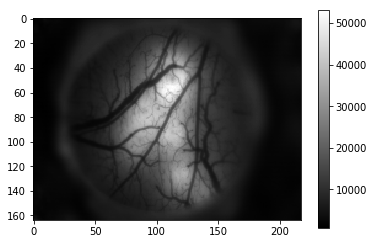

In [12]:
#vasculature_map = tf.imread('example_vasculature_map.tif')
vasculature_map = cv2.imread(surface_path, -1)
_ = plt.imshow(vasculature_map, cmap='gray', interpolation='nearest')
_ = plt.colorbar()
plt.show()

# Reading example retinotopic maps
cond1 = left
cond2 = right
cond3 = top
cond4 = bottom

In [19]:
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
for i, p in enumerate(mappaths):
    print(i, p)

condition_nums = {1: 'left',
                  2: 'right',
                  3: 'top',
                  4: 'bottom'}

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

mappath_d = {}
for mpath in mappaths:

    cond_name = re.findall(r'cond\d{1}_maps', mpath)[0]
    cond_num = int(re.findall(r'\d{1}', cond_name)[0])
    curr_cond = condition_nums[cond_num]
    
    mappath_d.update({curr_cond: mpath})


(0, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC113/20191011/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191011_cond2_maps.npz')
(1, '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC113/20191011/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191011_cond3_maps.npz')


In [20]:
mappath_d

{'right': '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC113/20191011/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191011_cond2_maps.npz',
 'top': '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC113/20191011/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20191011_cond3_maps.npz'}

In [21]:
def convert_to_absolute(cond_data, smooth_fwhm=7, smooth=True, power_metric='mag'):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    
    '''
    vmin = 0
    vmax = 2*np.pi

    if len(cond_data.keys()) > 1:
        c1 = 'left' if 'left' in cond_data.keys() else 'top'
        c2 = 'right' if c1=='left' else 'bottom'
    
        # Phase maps
        if smooth:
            m1 = shift_map(smooth_array(cond_data[c1]['phaseMap'], smooth_fwhm, phaseArray=True))
            m2 = shift_map(smooth_array(cond_data[c2]['phaseMap'], smooth_fwhm, phaseArray=True))
        else:
            m1 = shift_map(cond_data[c1]['phaseMap'])
            m2 = shift_map(cond_data[c2]['phaseMap'])
            
        combined_phase_map = spstats.circmean(np.dstack([m1, m2]), axis=-1, low=vmin, high=vmax) 
        
        # Mag maps
        p1 = cond_data[c1]['%sMap' % power_metric]
        p2 = cond_data[c2]['%sMap' % power_metric]
        combined_mag_map = np.mean(np.dstack([p1, p2]), axis=-1)

    else:
        if 'right' in cond_data.keys() and 'top' not in cond_data.keys():
            m1 = cond_data['right']['phaseMap'].copy()
            m2 = cond_data['right']['phaseMap'].copy()*-1
            p1 = cond_data['right']['%sMap' % power_metric].copy()
            
        elif 'top' in cond_data.keys() and 'right' not in cond_data.keys():
            m1 = cond_data['top']['phaseMap'].copy()
            m2 = cond_data['top']['phaseMap'].copy()*-1
            p1 = cond_data['top']['%sMap' % power_metric].copy()
        
        # Phase maps
        combined_phase_map = (m2-m1)/2.
        
        # Mag maps
        combined_mag_map = p1
        
        if smooth:
            combined_phase_map = smooth_array(combined_phase_map, smooth_fwhm, phaseArray=True)
            combined_mag_map = smooth_array(combined_mag_map, smooth_fwhm, phaseArray=False)
        
        # Shift maps
        combined_phase_map = shift_map(combined_phase_map) # values should go from 0 to 2*pi        
    
    return combined_phase_map, combined_mag_map #_shift

In [22]:
# shift = True
# cmap = 'nipy_spectral'

# condition_keys = {'azimuth': ['left', 'right'],
#                   'altitude': ['top', 'bottom']}

    
# mapdata_az = np.load(mappaths[1]) if len(mappaths)==4 else np.load(mappaths[0]) 
# mapdata_el = np.load(mappaths[2]) if len(mappaths)==4 else np.load(mappaths[1]) 

# if shift:
#     altitude_map = shift_map(mapdata_el['phaseMap'].copy())
#     azimuth_map = shift_map(mapdata_az['phaseMap'].copy())
# else:
#     altitude_map = mapdata_el['phaseMap']
#     azimuth_map = mapdata_az['phaseMap']


In [25]:
shift = True
cmap = 'nipy_spectral'
smooth_fwhm = 7
smooth_first = True

vmin = 0 if shift else -np.pi
vmax = 2*np.pi if shift else np.pi

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

power_metric = 'mag'

mapdata = {}
all_mapdata = {}
for cond, bar_pos in condition_keys.items():
    
    cond_data = dict((bpos, np.load(mappath_d[bpos])) for bpos in bar_pos if bpos in mappath_d.keys())
    phasemap_, magmap_ = convert_to_absolute(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth_first)
    mapdata[cond] = {'phase': phasemap_, 
                     power_metric: magmap_}    

    
    all_mapdata.update(cond_data)
    

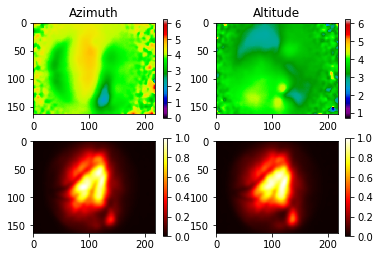

In [26]:

fig = plt.figure()

azi_map = mapdata['azimuth']['phase'].copy() #mapdata['azimuth'].copy()
alt_map = mapdata['altitude']['phase'].copy()
azi_pwr = mapdata['azimuth']['%s' % power_metric]/mapdata['azimuth']['%s' % power_metric].max()
alt_pwr = mapdata['altitude']['%s' % power_metric]/mapdata['altitude']['%s' % power_metric].max()

fig.add_subplot(221)
plt.imshow(azi_map, cmap='nipy_spectral', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Azimuth')

fig.add_subplot(222)
plt.imshow(alt_map, cmap='nipy_spectral') #,  vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Altitude')


fig.add_subplot(223)
plt.imshow(azi_pwr, cmap='hot', vmin=0, vmax=1)
plt.colorbar()

fig.add_subplot(224)
plt.imshow(alt_pwr, cmap='hot',  vmin=0, vmax=1)
plt.colorbar()

#### Convert to linear (screen) range

In [27]:
screen_w, screen_h = (117, 67)
screen_w_deg = screen_w/2.
screen_h_deg = screen_h/2.

print(screen_w_deg, screen_h_deg)


(58.5, 33.5)


Old min/max: 0.00, 6.28
[AZI] New min/max: -58.50, 58.50
[ALT] New min/max: -58.50, 58.50
(-22.70999410421463, 43.490229152754466)


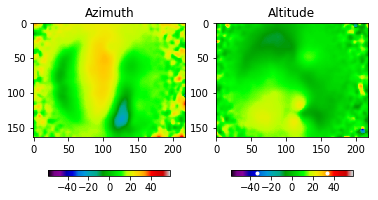

In [29]:
lmin_azi, lmax_azi = (-screen_w_deg, screen_w_deg)
lmin_alt, lmax_alt = (-screen_w_deg, screen_w_deg) #(-33.66, 33.66)
screen_h_min, screen_h_max = (-screen_h_deg, screen_h_deg)

print("Old min/max: %.2f, %.2f" % (vmin, vmax))
print("[AZI] New min/max: %.2f, %.2f" % (lmin_azi, lmax_azi))
print("[ALT] New min/max: %.2f, %.2f" % (lmin_alt, lmax_alt))


azi_lin = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin, oldmax=vmax)
alt_lin = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin, oldmax=vmax)

#phase_el_smooth = convert_range(phase_el_smooth, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)
#print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))

print(azi_lin.min(), azi_lin.max())
fig = plt.figure()

fig.add_subplot(121)
plt.title('Azimuth')
plt.imshow(azi_lin, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
plt.colorbar(orientation='horizontal', shrink=0.8)


fig.add_subplot(122)
plt.title('Altitude')
plt.imshow(alt_lin, cmap='nipy_spectral', vmin=lmin_alt, vmax=lmax_alt)
cb = plt.colorbar(orientation='horizontal', shrink=0.8)

screen_lim_pos = (lmax_alt-screen_h_max)/(lmax_alt*2.)
cb.ax.plot(screen_lim_pos, 0.5, 'w.') # my data is between 0 and 1
cb.ax.plot(1-screen_lim_pos, 0.5, 'w.') # my data is between 0 and 1

# cb.ax.axvline(x=screen_h_min, c='w')          # line at 3


## filter + smooth

In [2754]:
smooth_fwhm = 7
mag_thr=0.035


phase_az_raw = mapdata_az['phaseMap'].copy()
phase_el_raw = mapdata_el['phaseMap'].copy()
print(phase_el_raw.min(), phase_el_raw.max())

mag_az_raw = mapdata_az['magRatioMap'].copy()
mag_el_raw = mapdata_el['magRatioMap'].copy()

phase_az_smooth = shift_map(smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True))
phase_el_smooth = shift_map(smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True))
print(phase_el_smooth.min(), phase_el_smooth.max())


# print("pre-smooth", azi_map.min(), azi_map.max())

# phase_az_smooth = shift_map(smooth_array(azi_map, smooth_fwhm, phaseArray=True))
# phase_el_smooth = shift_map(smooth_array(alt_map, smooth_fwhm, phaseArray=True))

# print("post-smooth", phase_az_smooth.min(), phase_az_smooth.max())

# phase_az_smooth = smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True)
# phase_el_smooth = smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True)

mag_az_smooth = smooth_array(mag_az_raw, smooth_fwhm, phaseArray=False)
mag_el_smooth = smooth_array(mag_el_raw, smooth_fwhm, phaseArray=False)

# THR by mag
# phase_az_smooth[mag_az_smooth<mag_thr] = 0
# phase_el_smooth[mag_az_smooth<mag_thr] = 0 
# phase_el_smooth[mag_el_smooth<mag_thr] = 0 
# phase_az_smooth[mag_el_smooth<mag_thr] = 0

# normalize power
altitude_power_map_normed = mag_el_smooth/mag_el_smooth.max()
azimuth_power_map_normed = mag_az_smooth/mag_az_smooth.max()


(-3.141396687354129, 3.1415481797636)
(0.1347061876947222, 6.266005817642323)


In [2755]:
phase_az_smooth.min(), phase_az_smooth.max()

(0.00103596857954645, 6.273938196706305)

In [2757]:
print("max pwr: %.4f" % mag_az_smooth.max())
print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))
print("phase min/max: %.2f / %.2f" % (phase_el_smooth.min(), phase_el_smooth.max()))

max pwr: 0.2000
phase min/max: 0.00 / 6.27
phase min/max: 0.13 / 6.27


In [2758]:
## Convert to degrees
in_degrees = True

if shift:
    vmin_az, vmax_az = 0, 2*np.pi
    vmin_el, vmax_el = 0, 2*np.pi
else:
    vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
    vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

vmin_az, vmax_az = (phase_az_smooth[~np.isnan(phase_az_smooth)].min(), phase_az_smooth[~np.isnan(phase_az_smooth)].max())
vmin_el, vmax_el = (phase_el_smooth[~np.isnan(phase_el_smooth)].min(), phase_el_smooth[~np.isnan(phase_el_smooth)].max())

lmin_azi, lmax_azi = (-59.78, 59.78)
lmin_alt, lmax_alt = (-33.66, 33.66)

phase_az_smooth = convert_range(phase_az_smooth, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
phase_el_smooth = convert_range(phase_el_smooth, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)

print("phase min/max: %.2f / %.2f" % (phase_az_smooth.min(), phase_az_smooth.max()))

# # THR by mag
phase_az_smooth[mag_az_smooth<mag_thr] = 0
phase_el_smooth[mag_az_smooth<mag_thr] = 0 
phase_el_smooth[mag_el_smooth<mag_thr] = 0 
phase_az_smooth[mag_el_smooth<mag_thr] = 0


phase min/max: -59.78 / 59.78


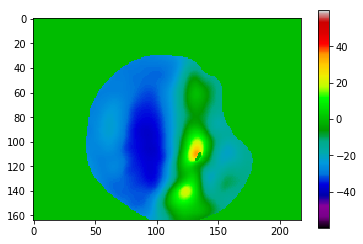

In [2759]:
plt.figure()
plt.imshow(phase_az_smooth, cmap='nipy_spectral', vmin=lmin_azi, vmax=lmax_azi)
plt.colorbar()

In [2760]:
reload()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Set output dir

In [30]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
base_dir = os.path.join(aggregate_dir, 'widefield-maps', 'signmaps')
dst_dir = os.path.join(base_dir, 'retinotopic-mapper', data_id)

print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC113_20191011


# Defining image analysis parameters  

#### This is probably the most important part of the whole analysis! The 14 parameters below define the final segmentation results.  
<br>
* phaseMapFilterSigma: The sigma value (in pixels) of Gaussian filter for altitude and azimuth maps. FLOAT, default = 1.0, recommended range: [0.0, 2.0]. Large "phaseMapFilterSigma" gives you more patches. Small "phaseMapFilterSigma" gives you less patches.
<br><br>
* signMapFilterSigma: The sigma value (in pixels) of Gaussian filter for visual sign maps. FLOAT, default = 9.0, recommended range: [0.6, 10.0]. Large "signMapFilterSigma" gives you less patches. Small "signMapFilterSigma" gives you more patches.
<br><br>
* signMapThr: Threshold to binarize visual signmap. FLOAT, default = 0.35, recommended range: [0.2, 0.5], allowed range: [0, 1). Large signMapThr gives you fewer patches. Smaller signMapThr gives you more patches.
<br><br>
* closeIter: Binary close iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often.
<br><br>
* openIter: Binary open iteration for each raw patches. INT, default = 3. You do not want to change this parameter very often
<br><br>
* dilationIter: Binary dilation iteration for each raw patches. INT, default = 15. You do not want to change this parameter very often. 
<br><br>
* borderWidth: Pixel number between adjcent patches. INT, default = 1. You do not want to change this parameter very often.
<br><br>
* smallPatchThr: The patches with pixel number below smallPatchThr will be discarded. INT, default = 100. You do not want to change this parameter very often.
<br><br>
* eccMapFilterSigma: The sigma value of Gaussian filter for eccentricity maps. FLOAT, default = 10.0. You do not want to change this parameter very often.
<br><br>
* visualSpacePixelSize: The pixel size for patch to visual space mapping. FLOAT, default = 0.5. You do not want to change this parameter very often. 
<br><br>
* visualSpaceCloseIter: The binary iteration for visual space coverage for each patch. INT, default = 15. You do not want to change this parameter very often.
<br><br>
* splitLocalMinCutStep: The step width for detecting number of local minimums during spliting. The local minimums detected will be used as marker in the following open cv watershed segmentation. FLOAT, default = 5.0, recommend range: [0.5, 15.0]. Small "splitLocalMinCutStep" will make it more likely to split but into less sub patches. Large "splitLocalMinCutStep" will make it less likely to split but into more sub patches. 
<br><br>
* splitOverlapThr: Patches with overlap ration larger than this value will go through the split procedure. FLOAT, default = 1.1, recommend range: [1.0, 1.2], should be larger than 1.0. Small "splitOverlapThr" will split more patches. Large "splitOverlapThr" will split less patches. 
<br><br>
* mergeOverlapThr: Considering a patch pair (A and B) with same sign, A has visual coverage a deg<sup>2</sup> and B has visual coverage b deg<sup>2</sup> and the overlaping visual coverage between this pair is c deg<sup>2</sup>. Then if (c/a < "mergeOverlapThr") and (c/b < "mergeOverlapThr"), these two patches will be merged. FLOAT, default = 0.1, recommend range: [0.0, 0.2], should be smaller than 1.0. Small "mergeOverlapThr" will merge less patches. Large "mergeOverlapThr" will merge more patches.

In [31]:
reload(rm)
import json

# Creating the RetinotopicMappingTrail object

In [232]:
mag_thr = 0.03

params = {
          'phaseMapFilterSigma': 1, #None, # 0,
          'signMapFilterSigma': 9., #5.,
          'signMapThr': 0.35, #0.35, #0.5,
          'eccMapFilterSigma': 5., #10.0,
          'splitLocalMinCutStep': 10., #5.,
          'closeIter': 3,
          'openIter': 3,
          'dilationIter': 15,
          'borderWidth': 1,
          'smallPatchThr': 100,
          'visualSpacePixelSize': 0.5, #0.5, #5,
          'visualSpaceCloseIter': 15,
          'splitOverlapThr': 1.1,
          'mergeOverlapThr': 0.1, #0.01,
          'lmin_alt': lmin_alt,
          'lmax_alt': lmax_alt, 
          'lmin_azi': lmin_azi,
          'lmax_azi': lmax_azi, 
          
          # preprocessing 
          'mag_thr': mag_thr,
          'smooth_fwhm': smooth_fwhm
          }


params_fpath = os.path.join(dst_dir, '%s_params2.json' % data_id)
with open(params_fpath, 'w') as f:
    json.dump(params, f, indent=4, sort_keys=True)

In [233]:
# altitude_phase_map = shift_map(phase_el_raw.copy()) #phase_el_smooth.copy()
# azimuth_phase_map = shift_map(phase_az_raw.copy()) #phase_az_smooth.copy()
# azimuth_phase_map = convert_range(azimuth_phase_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
# altitude_phase_map = convert_range(altitude_phase_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_el, oldmax=vmax_el)

vmin_az = 0
vmax_az= 2*np.pi

#phase_az_smooth = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin_az, oldmax=vmax_az)
#phase_el_smooth = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin_az, oldmax=vmax_az)

altitude_phase_map = alt_lin.copy()
azimuth_phase_map = azi_lin.copy()
altitude_power_map = alt_pwr.copy()
azimuth_power_map = azi_pwr.copy()
# altitude_phase_map = phase_el_smooth.copy()
# azimuth_phase_map = phase_az_smooth.copy()

# altitude_power_map = mag_el_smooth.copy()
# azimuth_power_map = mag_az_smooth.copy()

In [234]:
print(azimuth_phase_map.min(), azimuth_phase_map.max())

(-22.70999410421463, 43.490229152754466)


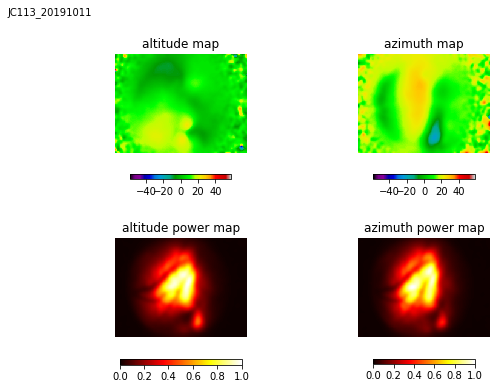

In [235]:
cmap = 'nipy_spectral'
in_degrees = True

f = plt.figure(figsize=(8, 6))
ax1 = f.add_subplot(221)
if in_degrees:
    vmin_az, vmax_az = (lmin_azi, lmax_azi)
    vmin_el, vmax_el = (lmin_alt, lmax_alt)
else:
    if shift:
        vmin_az, vmax_az = 0, 2*np.pi
        vmin_el, vmax_el = 0, 2*np.pi
    else:
        vmin_az, vmax_az = -np.pi, np.pi # (0, 120)
        vmin_el, vmax_el = -np.pi, np.pi # (-40, 60)

fig1 = ax1.imshow(altitude_phase_map, vmin=vmin_el, vmax=vmax_el, cmap=cmap, interpolation='nearest')
ax1.set_axis_off()
ax1.set_title('altitude map')
_ = f.colorbar(fig1, orientation='horizontal', shrink=0.5)

ax2 = f.add_subplot(222)
fig2 = ax2.imshow(azimuth_phase_map, vmin=vmin_az, vmax=vmax_az, cmap=cmap, interpolation='nearest')
ax2.set_axis_off()
ax2.set_title('azimuth map')
_ = f.colorbar(fig2, orientation='horizontal', shrink=0.5)

ax3 = f.add_subplot(223)
fig3 = ax3.imshow(altitude_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax3.set_axis_off()
ax3.set_title('altitude power map')
_ = f.colorbar(fig3, orientation='horizontal', shrink=0.6)

ax4 = f.add_subplot(224)
fig4 = ax4.imshow(azimuth_power_map, vmin=0, vmax=1, cmap='hot', interpolation='nearest')
ax4.set_axis_off()
ax4.set_title('azimuth power map')
_ = f.colorbar(fig4, orientation='horizontal', shrink=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.2)

label_figure(f, data_id)
plt.savefig(os.path.join(dst_dir, '%s_input_maps2.png' % data_id))

# Create trial object

In [236]:
reload(rm)

<module 'retinotopic_mapping.RetinotopicMapping' from '/home/julianarhee/anaconda2/envs/retinotopic_mapping/lib/python2.7/site-packages/retinotopic_mapping-2.9.4-py2.7.egg/retinotopic_mapping/RetinotopicMapping.pyc'>

In [237]:

# Create trial object
trial = rm.RetinotopicMappingTrial(altPosMap=alt_lin, #altitude_phase_map,
                                   aziPosMap=azi_lin, #azimuth_phase_map,
                                   altPowerMap=alt_pwr, #altitude_power_map,
                                   aziPowerMap=azi_pwr, #azimuth_power_map,
                                   vasculatureMap=vasculature_map,
                                   mouseID=animalid,
                                   dateRecorded=session,
                                   comments='This is an example.',
                                   params=params)

In [238]:
print trial

A retinotopic mapping trial: 20191011_MJC113


# Generating visual sign map

In [239]:
trial.getName()

'20191011_MJC113'

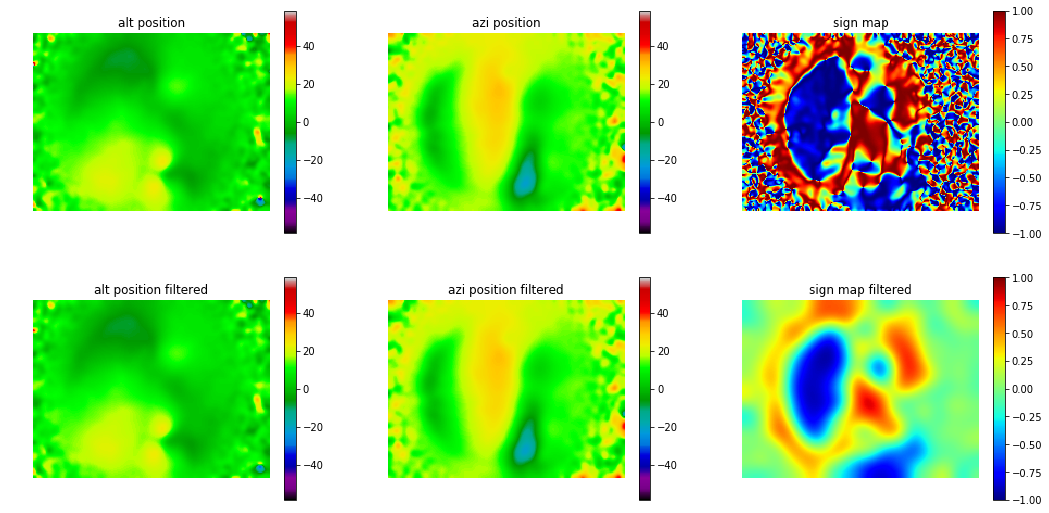

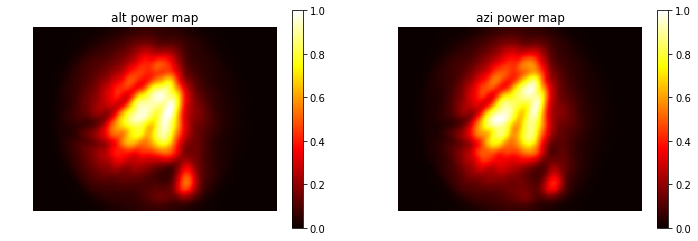

In [240]:
_ = trial._getSignMap(isPlot=True, isFixedRange=True, cmap='nipy_spectral')
# f1 = plot_getSignMap(trial, isFixedRange=True)

# label_figure(f1, data_id)
#plt.savefig(os.path.join(dst_dir, '%s_get_sign_map.png' % data_id))

In [241]:
trial.params['lmin_alt'], trial.params['lmax_alt']

(-58.5, 58.5)

patch09AU=162.5 AS=162.15886414537408 ratio=0.9979007024330713
patch08AU=29.25 AS=23.39065450553055 ratio=0.7996804959155743
patch05AU=192.25 AS=198.24806933808821 ratio=1.031199320354165
patch04AU=426.0 AS=820.1462090689372 ratio=1.925225842884829
Only one local minumum was found!!!
patch07AU=127.5 AS=131.68405591701412 ratio=1.0328161248393264
patch06AU=157.25 AS=148.57404643288424 ratio=0.9448270043426661
patch01AU=694.0 AS=695.0577102399205 ratio=1.001524078155505
patch03AU=654.5 AS=1032.9182252767605 ratio=1.5781791066107875
Only one local minumum was found!!!
patch02AU=155.75 AS=143.20546597641984 ratio=0.9194572454344774
merge iteration: 1
merging: patch05 & patch07, overlap ratio: 0.049019607843137254
merge iteration: 2


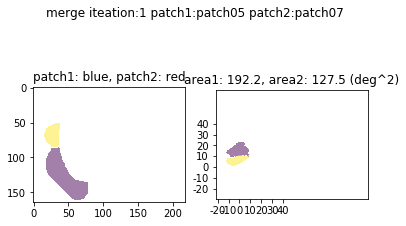

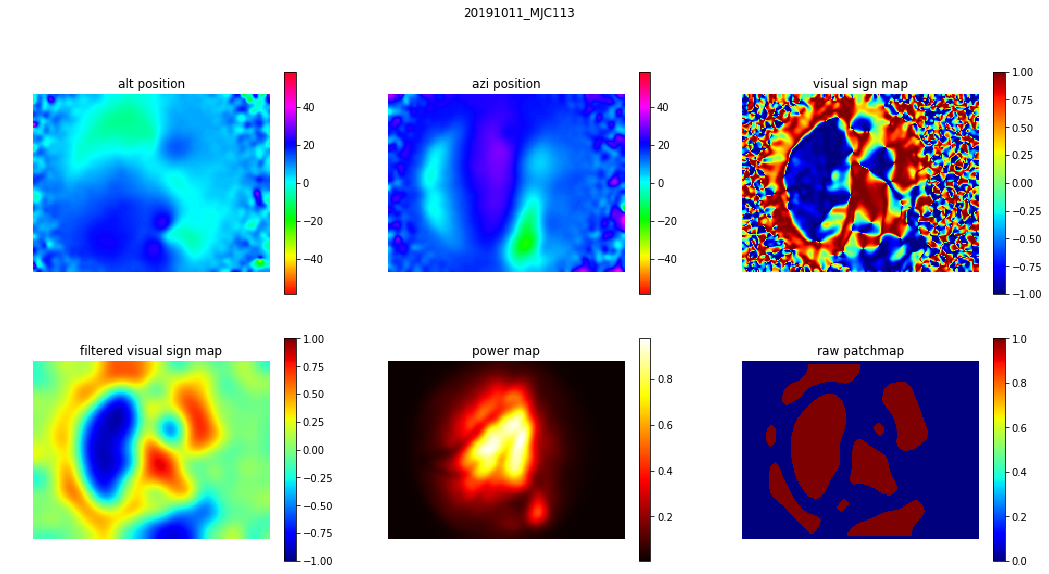

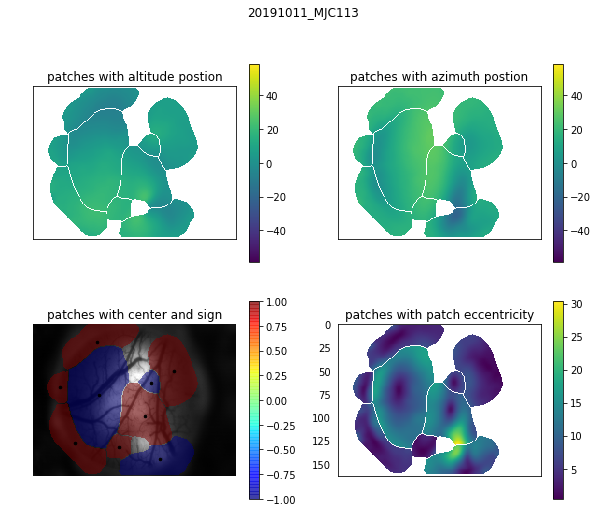

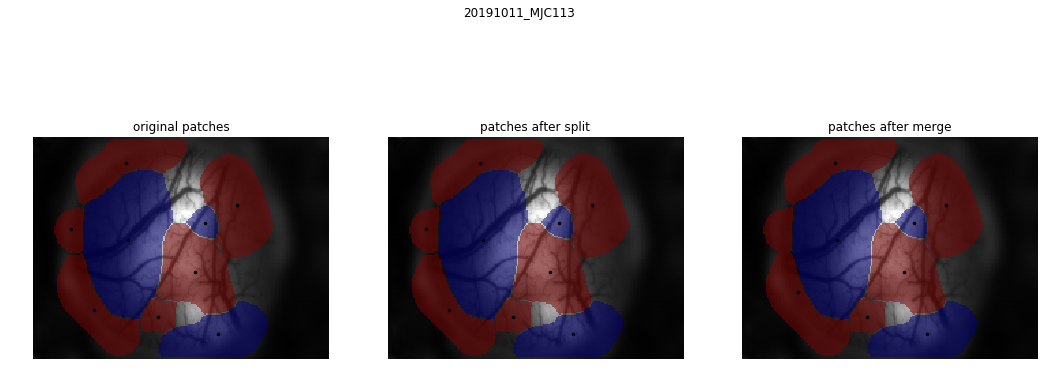

In [242]:
trial.plotTrial(isSave=True, saveFolder=dst_dir)

# Binarizing filtered visual signmap

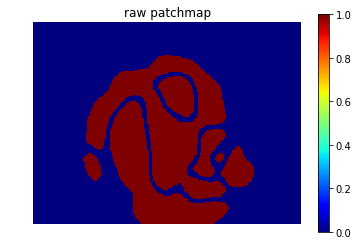

In [2786]:
_ = trial._getRawPatchMap(isPlot=True)
plt.show()

# Generating raw patches

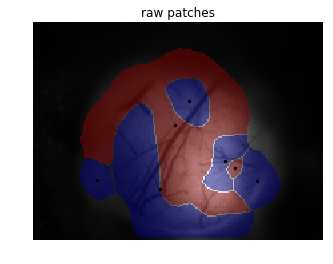

In [2787]:
_ = trial._getRawPatches(isPlot=True)
plt.show()

# Generating determinant map

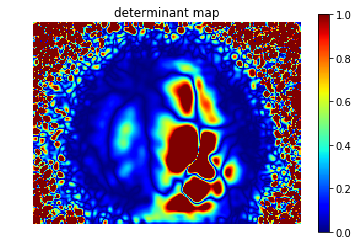

In [3013]:
_ = trial._getDeterminantMap(isPlot=True, cmap='jet')
plt.show()

# Generating eccentricity map for each patch

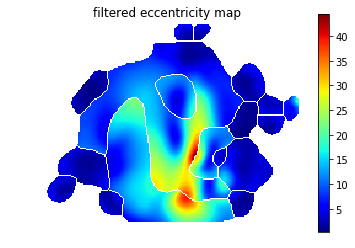

In [3014]:
_ = trial._getEccentricityMap(isPlot=True)
plt.show()

# Splitting overlapping patches

patch05AU=545.25 AS=1003.0829859450821 ratio=1.8396753524898342
Only one local minumum was found!!!
patch04AU=21.25 AS=295.657594152446 ratio=13.913298548350399
Only one local minumum was found!!!
patch07AU=0.0 AS=30.9808020250639 ratio=inf
Only one local minumum was found!!!
patch06AU=0.25 AS=60.911706299552364 ratio=243.64682519820946
Only one local minumum was found!!!
patch01AU=691.25 AS=2492.8541634256753 ratio=3.606298970597722
7 local minuma were found!!!
patch03AU=0.25 AS=130.71051207625507 ratio=522.8420483050203
Only one local minumum was found!!!
patch02AU=314.0 AS=839.3131880338152 ratio=2.672971936413424
2 local minuma were found!!!


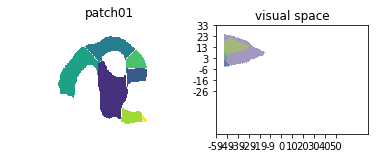

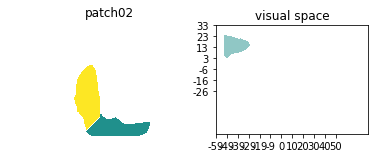

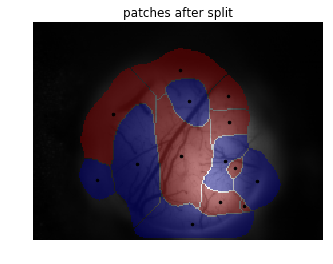

In [2790]:
_ = trial._splitPatches(isPlot=True)
plt.show()

# Merging non-overlapping patches

merge iteration: 1


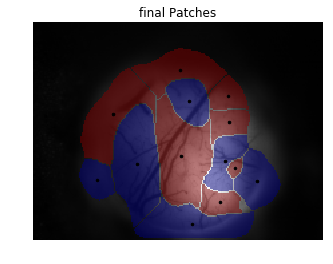

In [2791]:
_ = trial._mergePatches(isPlot=True)
plt.show()

## Note:  
### The methods used from cell 8 to cell 14 are protected by leading underscore! Here they were used separately to show every single image analysis step. In real life, the steps from cell 8 to cell 14 can be consolidated into one single method:  

`trial.processTrial(isPlot=True)`

# Plotting results

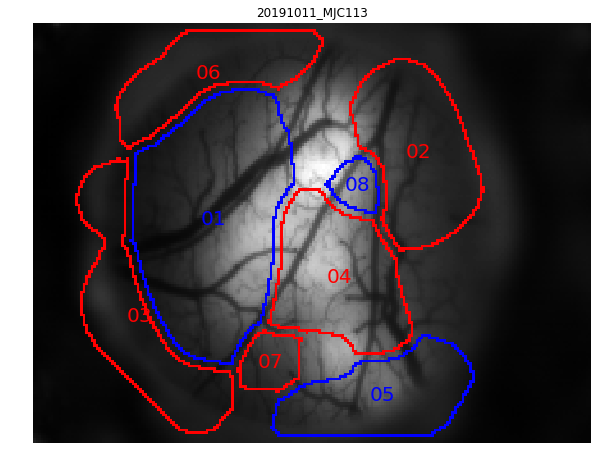

In [243]:
f = trial.plotFinalPatchBorders(borderWidth=2, fontSize=20)

#plt.show()

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders.png' % trial.getName()))
plt.show()


# Annotating segmented patches

In [246]:
names = [
         ['patch01', 'V1'],
         ['patch04', 'LMa'],
         ['patch07', 'LMb'],
         ['patch05', 'LI'],
         ['patch08', 'AL'],
#          ['patch23', 'LL'],

    #          ['patch13', 'LL'],
#          ['patch06', 'AM'],
#          ['patch07', 'LI'],
#          ['patch08', 'MMA'],
#          ['patch09', 'AL'],
#          ['patch10', 'RLL'],
#          ['patch11', 'LLA'],
         ]

finalPatchesMarked = dict(trial.finalPatches)

for i, namePair in enumerate(names):
    currPatch = finalPatchesMarked.pop(namePair[0])
    newPatchDict = {namePair[1]:currPatch}
    finalPatchesMarked.update(newPatchDict)
    
trial.finalPatchesMarked = finalPatchesMarked

# Ploting final results

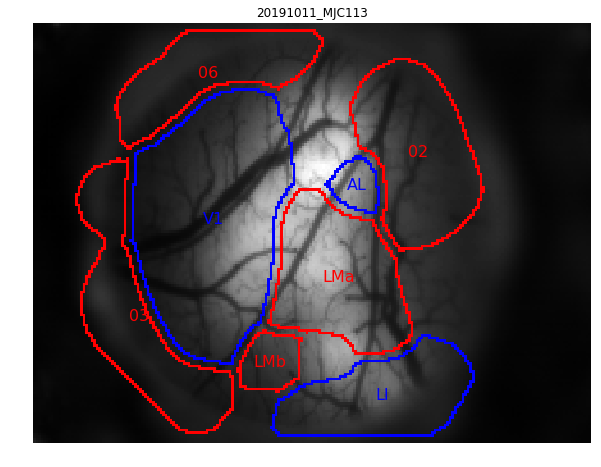

In [247]:
_ = trial.plotFinalPatchBorders()

plt.savefig(os.path.join(dst_dir, '%s_final_patch_borders_labeled.png' % trial.getName()))

plt.show()

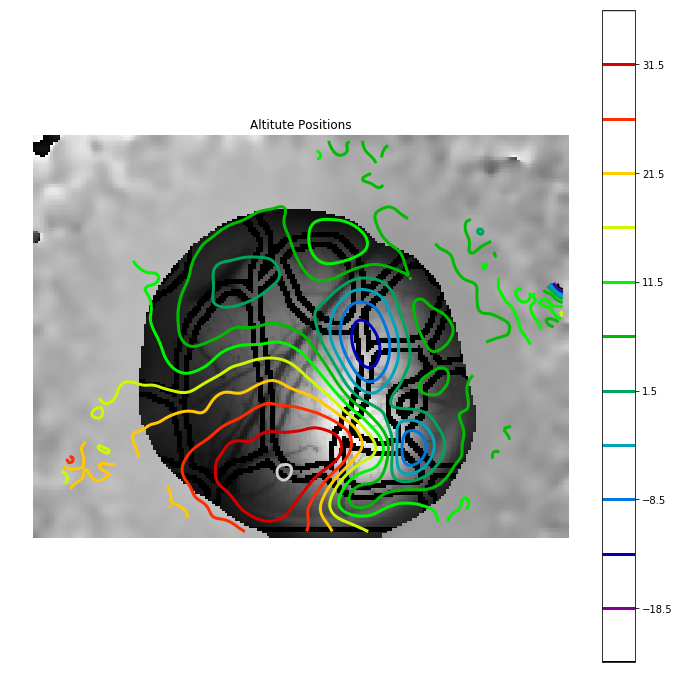

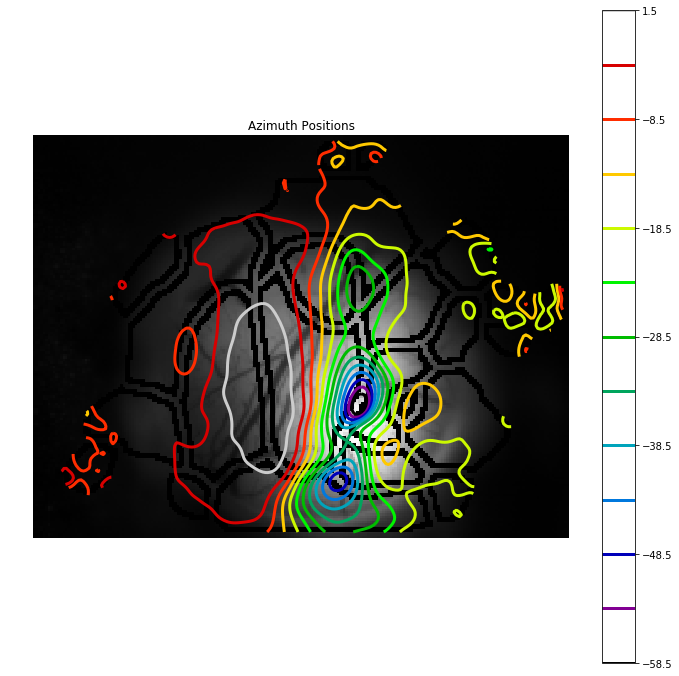

In [3035]:
contour_alt, contour_azi = trial.plotContours(cmap='nipy_spectral', inline=False)

contour_alt.imshow(azi_msk, cmap='gray')

# Generating dictionary for saving

In [248]:
trialDict = trial.generateTrialDict()
trialDict.keys()

['eccentricityMapf',
 'mouseID',
 'aziPowerMap',
 'altPosMapf',
 'altPowerMap',
 'aziPowerMapf',
 'comments',
 'aziPosMap',
 'altPosMap',
 'finalPatchesMarked',
 'signMapf',
 'params',
 'finalPatches',
 'vasculatureMap',
 'signMap',
 'dateRecorded',
 'altPowerMapf',
 'rawPatchMap',
 'aziPosMapf']

# Saving results

In [249]:
results_fpath = os.path.join(dst_dir, '%s_results.pkl' % trial.getName())
ft.saveFile(results_fpath, trialDict)
print("saved results: ", results_fpath)

('saved results: ', '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC113_20191011/20191011_MJC113_results.pkl')


In [250]:
results_fpath

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC113_20191011/20191011_MJC113_results.pkl'